## BIOS740 HW1: Predicting Alzheimer's Disease Status Using Hippocampal Data

Alzheimer's Disease (AD) is a neurodegenerative disorder characterized by progressive cognitive decline. Atrophy in the hippocampus, a brain region critical for memory formation, is one of the early biomarkers of AD. In this assignment, you are provided with left and right hippocampus matrices in compressed CSV format for 369 subjects from ADNI. Each matrix represents imaging data preprocessed and extracted from MRI scans. Your task is to develop a Convolutional Neural Network (CNN) model to predict the AD status of subjects based on their hippocampal data. 


## Import and check environment

In [1]:
import sys
import os, re, glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
import pytorch_lightning as pl
from torchvision import models
import torchvision.transforms.functional as TF
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import matplotlib.pyplot as plt

print("-------- Checking Imports ---------")
print("All imports are successsful!")
print(sys.executable)
print()

print("-------- Checking GPU -------------")
print("cuda available:", torch.cuda.is_available())
print("device count:", torch.cuda.device_count())
print("name:", torch.cuda.get_device_name(0))
print("capability:", torch.cuda.get_device_capability(0))
print("memory GB (approx):", torch.cuda.get_device_properties(0).total_memory/1024**3)
print()

-------- Checking Imports ---------
All imports are successsful!
/nas/longleaf/home/fangliu/.conda/envs/torch_env/bin/python

-------- Checking GPU -------------
cuda available: True
device count: 1
name: NVIDIA A100-PCIE-40GB MIG 2g.10gb
capability: (8, 0)
memory GB (approx): 9.75



## 1. Data Preprocessing and Loading

### Preprocessing

We could write some helper functions to help us with preprocessing. File names that could not be parsed are discarded. If subject does not have matching left and right hippocampus files, the samples are discarded. 

In [2]:
# Optional: drop samples if nearest diagnosis is too far away (days). None = keep all.
MAX_DELTA_DAYS = None  # e.g., 180

# Parse: 002_S_0295__2006-05-09__S118671.5T.csv.gz
# NOTE: tag can contain dots; capture everything up to ".csv"
FNAME_RE = re.compile(
    r"^(?P<ptid>\d+_S_\d+)__(?P<date>\d{4}-\d{2}-\d{2})__(?P<tag>.+?)\.csv(?:\.gz)?$"
)

def parse_fname(path: str):
    base = os.path.basename(path)
    m = FNAME_RE.match(base)
    if not m:
        return None
    return m.group("ptid"), m.group("date"), m.group("tag"), base

def build_paired_samples(left_dir: str, right_dir: str) -> pd.DataFrame:
    left_files  = glob.glob(os.path.join(left_dir, "*.csv")) + glob.glob(os.path.join(left_dir, "*.csv.gz"))
    right_files = glob.glob(os.path.join(right_dir, "*.csv")) + glob.glob(os.path.join(right_dir, "*.csv.gz"))

    # key by (PTID, EXAMDATE, TAG) instead of basename (more robust)
    left_map = {}
    for p in left_files:
        parsed = parse_fname(p)
        if not parsed:
            continue
        ptid, date, tag, _ = parsed
        left_map[(ptid, date, tag)] = p

    right_map = {}
    for p in right_files:
        parsed = parse_fname(p)
        if not parsed:
            continue
        ptid, date, tag, _ = parsed
        right_map[(ptid, date, tag)] = p

    #common_keys = sorted list of keys that appear in both left_map and right_map
    common_keys = sorted(set(left_map) & set(right_map))

    rows = []
    for (ptid, date, tag) in common_keys:
        rows.append({
            "PTID": ptid,
            "EXAMDATE_FILE": date,
            "TAG": tag,
            "LeftFile": left_map[(ptid, date, tag)],
            "RightFile": right_map[(ptid, date, tag)],
        })
    return pd.DataFrame(rows)


Next, we need to group and normalize labels so that similar diagnoses are grouped together. All labels with missing exam dates and normalized diagnoses are dropped. Duplicates are also dropped. We then match the normalized labels to the data. If there is no EXACT match between scan exam date and label exam date, we find the nearest-date match for the scan. This is controlled by 'delta'. 

In [3]:
# normalized diagnosis
def normalize_dx(dx: str):
    if pd.isna(dx):
        return None
    dx = str(dx).strip()
    if dx == "":
        return None
    u = dx.upper()
    if u in {"CN", "NC", "SMC"}:
        return "CN"
    if u in {"MCI", "EMCI", "LMCI"} or "MCI" in u:
        return "MCI"
    if u in {"AD", "DEMENTIA"} or "DEMENT" in u:
        return "AD"
    return None

# create table with exam date, normalized_DX
def build_dx_index(adnimerge_csv: str):
    df = pd.read_csv(adnimerge_csv, dtype=str)
    if "PTID" not in df.columns or "EXAMDATE" not in df.columns:
        raise ValueError("ADNIMERGE must have PTID and EXAMDATE.")

    dx_col = "DX" if "DX" in df.columns else ("DX_bl" if "DX_bl" in df.columns else None)
    if dx_col is None:
        raise ValueError("ADNIMERGE has neither DX nor DX_bl.")

    df = df[["PTID", "EXAMDATE", dx_col]].copy()
    df["EXAMDATE"] = pd.to_datetime(df["EXAMDATE"], errors="coerce")
    df["DX_NORM"] = df[dx_col].apply(normalize_dx)
    df = df.dropna(subset=["EXAMDATE", "DX_NORM"])

    out = {}
    for ptid, g in df.groupby("PTID"):
        gg = g[["EXAMDATE", "DX_NORM"]].drop_duplicates().sort_values("EXAMDATE").reset_index(drop=True)
        out[ptid] = gg
    return out

# match labels to data
def match_dx_for_sample(ptid: str, examdate_str: str, dx_index, max_delta_days=None):
    examdate = pd.to_datetime(examdate_str, errors="coerce")
    if pd.isna(examdate) or ptid not in dx_index or dx_index[ptid].empty:
        return None, None, None

    g = dx_index[ptid]
    exact = g[g["EXAMDATE"] == examdate]
    if not exact.empty:
        return exact.iloc[0]["DX_NORM"], examdate, 0

    deltas = (g["EXAMDATE"] - examdate).abs()
    i = int(deltas.idxmin())
    matched_date = g.loc[i, "EXAMDATE"]
    dx = g.loc[i, "DX_NORM"]
    delta_days = int(abs((matched_date - examdate).days))

    if max_delta_days is not None and delta_days > max_delta_days:
        return None, matched_date, delta_days
    return dx, matched_date, delta_days

Next, we can utilize the helpful functions above to create a clean dataset. 

In [4]:
# configurations
#location of directories
BASE = f"/work/users/f/a/fangliu/hw1"
adnimerge_csv = f"{BASE}/ADNIMERGE_01Oct2024.csv"
left_hippo_dir  = f"{BASE}/LeftCSV_organized/"
right_hippo_dir = f"{BASE}/RightCSV_organized/"

#check if files exist 
print("---------- Checking files -----------")
print("adnimerge exists:", os.path.exists(adnimerge_csv))
print("left dir exists:", os.path.exists(left_hippo_dir))
print("right dir exists:", os.path.exists(right_hippo_dir))
print()

---------- Checking files -----------
adnimerge exists: True
left dir exists: True
right dir exists: True



In [5]:
# Build all paired samples + label from nearest DX

samples_df = build_paired_samples(left_hippo_dir, right_hippo_dir)
dx_index = build_dx_index(adnimerge_csv)

dx_list, matched_list, delta_list = [], [], []
for _, r in samples_df.iterrows():
    dx, mdate, delta = match_dx_for_sample(
        r["PTID"], r["EXAMDATE_FILE"], dx_index, max_delta_days=MAX_DELTA_DAYS
    )
    dx_list.append(dx)
    matched_list.append(mdate.strftime("%Y-%m-%d") if mdate is not None else None)
    delta_list.append(delta)

samples_df["DX_NORM"] = dx_list
samples_df["EXAMDATE_MATCHED"] = matched_list
samples_df["DELTA_DAYS"] = delta_list

# keep labeled only
samples_df = samples_df.dropna(subset=["DX_NORM"]).reset_index(drop=True)

label_order = ["CN", "MCI", "AD"]
label_to_index = {lab: i for i, lab in enumerate(label_order)}
samples_df["label_idx"] = samples_df["DX_NORM"].map(label_to_index).astype(int)

samples_df.to_csv("samples_with_dx_manifest.tsv", sep="\t", index=False)

# only keep AD and CN, drop MCI
samples_df = samples_df[samples_df["DX_NORM"].isin(["AD", "CN"])].reset_index(drop=True)
samples_df["label_idx"] = samples_df["DX_NORM"].map({"CN": 0, "AD": 1}).astype(int)

#### DEBUGGING ONLY ####
print("------- Peek the data -----------")
print(samples_df.head(3))
print()
print("[INFO] Paired samples:", samples_df.shape[0])
print(samples_df["DX_NORM"].value_counts())
print()

------- Peek the data -----------
         PTID EXAMDATE_FILE         TAG  \
0  002_S_0295    2006-05-09  S118671.5T   
1  002_S_0295    2006-11-02  S118692.5T   
2  002_S_0295    2007-05-25   S64025.5T   

                                            LeftFile  \
0  /work/users/f/a/fangliu/hw1/LeftCSV_organized/...   
1  /work/users/f/a/fangliu/hw1/LeftCSV_organized/...   
2  /work/users/f/a/fangliu/hw1/LeftCSV_organized/...   

                                           RightFile DX_NORM EXAMDATE_MATCHED  \
0  /work/users/f/a/fangliu/hw1/RightCSV_organized...      CN       2006-05-09   
1  /work/users/f/a/fangliu/hw1/RightCSV_organized...      CN       2006-11-02   
2  /work/users/f/a/fangliu/hw1/RightCSV_organized...      CN       2007-05-25   

   DELTA_DAYS  label_idx  
0         0.0          0  
1         0.0          0  
2         0.0          0  

[INFO] Paired samples: 3855
DX_NORM
CN    2397
AD    1458
Name: count, dtype: int64



### Data loading

First, we decompress and load the csv file with the hippocampal matrices with pandas. The shape of the data is (15000, 7), meaning there is 15000 locations and 7 feature channels. After concatenating the left and right hippocampus data along the feature dimension, the shape is (15000, 14). Next we reshape this into (14, 150, 100) and convert to a torch rank-3 tensor so we could use pytorch. We need to normalize each feature channel.

In [6]:
#load the hippocampus data
class HippocampusDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return self.df.shape[0]

    def _read_matrix(self, path: str) -> np.ndarray:
        # .gz handled automatically by pandas
        return pd.read_csv(path, header=None, sep=r"\s+", engine="python").values

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        left  = self._read_matrix(row["LeftFile"]).astype(np.float32)   # (15000, 7)
        right = self._read_matrix(row["RightFile"]).astype(np.float32)  # (15000, 7)

        ##########################################################
        # 1. Concatenate the left and right hippocampus data along the feature dimension => (15000, 14)
        # 2. Transpose to get (14, 15000)
        # 3. Reshape each feature into (14, 150, 100)
        # 4. Convert to torch tensor and normalize per feature channel
        ##########################################################

        # Step 1: Concatenate -> (15000, 14)
        sample = np.concatenate([left, right], axis=1)
        
        # Optional safety checks
        if sample.shape != (15000, 14):
            raise ValueError(f"Unexpected sample shape {sample.shape} for idx={idx}")
        
        # Step 2: Transpose -> (14, 15000)
        sample = sample.T
        
        # Step 3: Reshape -> (14, 150, 100)
        sample = sample.reshape(14, 150, 100)
        
        # Step 4a: Convert to torch tensor -> float32
        sample = torch.from_numpy(sample).float()
        
        # Step 4b: Normalize each feature channel (per-sample, per-channel)
        # mean/std over spatial dims (150,100) for each channel
        mean = sample.mean(dim=(1, 2), keepdim=True)
        std  = sample.std(dim=(1, 2), keepdim=True)
        # avoid divide-by-zero
        sample = (sample - mean) / (std + 1e-6)

        ##########################################################
        # END OF YOUR CODE
        ##########################################################

        label = int(row["label_idx"])
        return sample, label

## 2. Model Development

### CNN Architecture Design

Number and types of layers
- We have 3 convolution layers in total. Each layer have increased channels so that we could learn complex features (14 - 32 - 64 - 128). Each convolution layer is followed by pooling. Pooling help reduces the spatial dimension of feature maps and help decrease computational costs & reduce # of parameters to prevent overfitting. It keeps the key info but removes redundant details. We then have two fully connected layer at the end used for classicification of AD vs. CN. 

Kernel sizes, strides, and padding
- We used an clasic kernel size of 3x3 (instead of 5x5) to capture local patterns in the data. The default stride of 1 is used so that we maximize the usage of our data. Similarly, padding of 1 is used (i.e., adding a layer of 0s around all borders) so that we can capture data near the edge. Without padding, the data near the edge will only be used once and thus we could miss some patterns. 

Activation functions
- The classic ReLU is used as the activation function to introduce non-liinearity. Without it, the layers could only learn linear transformations of the input data, which is too stict of a space. Recall that a deep stack of linear layers would still implement linear operation. An non-linearity function such as relu is used here so we have a better hypothesis space to work with. In our model, we use ReLu after each convolution layer (i.e., conv + ReLu + pool).  

Regularization techniques 
- The goal of regularization is to impede the model's ability to fit perfectly to the training data, thus making the model perform better during validation. Doing so usually makes the model simpler, reular, and generic - less specific to the training data and better generalization. We use dropout before our fully connected layers in order to prevent overfitting. 

### Implementation

In [7]:
class Trainer(pl.LightningModule):
    def __init__(self, model: nn.Module, lr: float = 1e-3):
        super(Trainer, self).__init__()
        if model is None:
            raise ValueError("LitModel requires a model (nn.Module).")
        self.model = model
        self.lr = lr
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):  
        return self.model(x)
        
    def training_step(self, batch, batch_idx):
        data, labels = batch
        labels = labels.long()
        logits = self(data)
        loss = self.criterion(logits, labels)
        preds = logits.argmax(dim=1)
        acc = (preds == labels).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        data, labels = batch
        labels = labels.long()
        logits = self(data)
        loss = self.criterion(logits, labels)
        preds = logits.argmax(dim=1)
        acc = (preds == labels).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=False)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [8]:
def calculate_output_shape(height, width):
    """
    Helper to compute output (height, width) after convolution block
    """
    for _ in range(3):
        # Convolution layer
        height = ((height + 2*1 - (3 - 1) - 1) // 1) + 1
        width  = ((width  + 2*1 - (3 - 1) - 1) // 1) + 1
        
        # Pooling layer
        height = ((height - (2 - 1) - 1) // 2) + 1
        width  = ((width  - (2 - 1) - 1) // 2) + 1
    
    return height, width
#calculate_output_shape(150, 100) 

The function here helps us calculate the shape of the output after our convolution+pooling blocks. Next we can implement CNN with PyTorch.

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2): #num_classes=2 → binary classification
        super(SimpleCNN, self).__init__()
        
        ##########################################################
        # 1) Three 2D convolutional layers
        # 2) A MaxPool2d layer self.pool
        # 3) A Dropout layer self.dropout with probability 0.5
        # 4) Two fully connected layers
        #    -> Remember to compute in_features for self.fc1 based on
        #       the output shape after the Conv+Pool layers.
        ##########################################################

        # Conv2d: in_channels=14  (since your data has shape [B, 14, 150, 100])
        #          out_channels=32/64/128
        #          kernel_size=3, stride=1, padding=1 (typical “same” conv)

        # Convs
        self.conv1 = nn.Conv2d(in_channels=14, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Pool; MaxPool2d: kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout
        self.dropout = nn.Dropout(p=0.5)

        # Output spatial output size after 3 conv+pool layers starting from (150,100)
        out_h, out_w = calculate_output_shape(150, 100)   # should be (18,12)

        # Fully Connected layers
        # After the last conv/pool, you have 128 channels with size out_h x out_w
        self.fc1 = nn.Linear(128 * out_h * out_w, 256)
        self.fc2 = nn.Linear(256, num_classes)


    def forward(self, x):
        """
        Forward pass:
        x shape = [batch_size, 14, 150, 100]
        """
        # 1) First conv + ReLU + pool
        x = F.relu(self.conv1(x))  # [B, 32, 150, 100]
        x = self.pool(x)           # [B, 32,  75,  50]

        # 2) Second conv + ReLU + pool
        x = F.relu(self.conv2(x))  # [B, 64,  75,  50]
        x = self.pool(x)           # [B, 64,  37,  25]

        # 3) Third conv + ReLU + pool
        x = F.relu(self.conv3(x))  # [B, 128, 37,  25]
        x = self.pool(x)           # [B, 128, 18,  12]

        # Flatten
        x = x.view(x.size(0), -1)  # [B, 128*18*12]
        x = self.dropout(x)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()  


Let's run a sanity test on the model before training. 

In [10]:
### sanity test this before training ###
model = SimpleCNN(num_classes=2)
model.eval()

#create a tensor with the same shape as our data
x = torch.randn(2, 14, 150, 100)
with torch.no_grad():
    y = model(x)
print("------------ Sanity Test for CNN --------------")
print("Output shape:", y.shape) # should be [batch_size, 2]
print("Output tensor:", y)
print()

------------ Sanity Test for CNN --------------
Output shape: torch.Size([2, 2])
Output tensor: tensor([[ 0.0781, -0.1661],
        [ 0.0622, -0.1459]])



### Adopt modern CNN - VGGLite

Next, we can try implementing a "lite" version of VGG, a classic deep convolutional neural network architecture. Here we add an extra layer on top of 3-layer CNN from earlier, resulting in 4 convolution blocks.

In [11]:
class VGGLite4(nn.Module):
    def __init__(self, in_channels=14, num_classes=2, dropout=0.5):
        super().__init__()

        def block(cin, cout):
            return nn.Sequential(
                nn.Conv2d(cin, cout, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(cout),
                nn.ReLU(inplace=True),
                nn.Conv2d(cout, cout, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(cout),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )

        # 4 conv blocks (this is the “extra” depth vs your 3-layer CNN)
        self.features = nn.Sequential(
            block(in_channels, 32),   # [B, 32, 75, 50]
            block(32, 64),            # [B, 64, 37, 25]
            block(64, 128),           # [B,128, 18, 12]
            block(128, 256),          # [B,256,  9,  6]
        )

        # Global pooling makes you NOT worry about exact H/W
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # [B, 256, 1, 1]

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),                 # [B, 256]
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes),  # logits [B, 2]
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x


In [12]:
### sanity test before training ###
model_vgg = VGGLite4(in_channels=14, num_classes=2)
model_vgg.eval()

# create a fake batch with the same shape as your real data
x = torch.randn(2, 14, 150, 100)

with torch.no_grad():
    y = model_vgg(x)

print("------------ Sanity Test for VGGLite4 --------------")
print("Output shape:", y.shape)   # should be [2, 2]
print("Output tensor:", y)
print()


------------ Sanity Test for VGGLite4 --------------
Output shape: torch.Size([2, 2])
Output tensor: tensor([[-0.0758,  0.0767],
        [-0.0758,  0.0767]])



## 3. Training and Validation

### Data Splitting

We perform a classic **80/10/10** training-validation-testing split. Adding "validation" set prevents overfitting compared to a simple 80/20 (train/test) split. If we only use our test set to fine-tune the model, the model eventually "leaks" information from that teset set. This will result in high accuracy that might be caused by the model memorizing the test data rather than truly learning from the patterns. This way our test data is untouched and can reflect how good our model is.

In [13]:
# ----------------------------
# Split by subject (PTID) to avoid leakage across timepoints
# two-stage, patient-level shuffle split to create train/validation/test sets (≈80/10/10) while guaranteeing no PTID leakage across splits
# ----------------------------

groups = samples_df["PTID"].values
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, temp_idx = next(gss1.split(samples_df, groups=groups))

train_df = samples_df.iloc[train_idx].reset_index(drop=True)
temp_df  = samples_df.iloc[temp_idx].reset_index(drop=True)

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(gss2.split(temp_df, groups=temp_df["PTID"].values))

val_df  = temp_df.iloc[val_idx].reset_index(drop=True)
test_df = temp_df.iloc[test_idx].reset_index(drop=True)

train_dataset = HippocampusDataset(train_df)
val_dataset   = HippocampusDataset(val_df)
test_dataset  = HippocampusDataset(test_df)


## NOTE: could increase num_workers when I request more CPUs! ##
NUM_WORKERS = 2
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True,
                          persistent_workers=(NUM_WORKERS > 0))
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True,
                          persistent_workers=(NUM_WORKERS > 0))
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True,
                          persistent_workers=(NUM_WORKERS > 0))

print("-------------- CPU information -------------")
print("CPU affinity:", len(os.sched_getaffinity(0)))
print("cpu_count:", os.cpu_count())
print()

-------------- CPU information -------------
CPU affinity: 1
cpu_count: 128



/nas/longleaf/home/fangliu/.conda/envs/torch_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


We can check if subjects overlap across splits and check the number of unique subjects in each split.

In [14]:
## DEBUG ONLY - verify no subject overlap across splits ##
#number of unique patient IDs in each set
train_ptids = set(train_df["PTID"])
val_ptids   = set(val_df["PTID"])
test_ptids  = set(test_df["PTID"])

#check if subjects overlap across splits
print("-------------- Checking Data Splits ----------------")
print("training & validation overlap:", len(train_ptids & val_ptids))
print("training & testing overlap:", len(train_ptids & test_ptids))
print("validation & testing overlap:", len(val_ptids & test_ptids))
print() 

#check # of unique subjects in each (80/10/10 split)
print("# of unique subjects:", samples_df["PTID"].nunique())
print("# of unique subjects in train:", len(train_ptids))
print("# of uinque subjects in val:", len(val_ptids))
print("# of unique subjects in test:", len(test_ptids))
print()

#check # of samples in each set
print(f"The training set contain {len(train_dataset)} samples.")
print(f"The validation set contain {len(val_dataset)} samples.")
print(f"The testing set contain {len(test_dataset)} samples.")
print(f"Each sample has shape {train_dataset[0][0].shape}.") 
print()
#PyTorch expects [C = Channels, H = Height, W = Width]; always uses channels first! 

## check if normalization is done correctly ###
#x, _ = train_dataset[0]
#print("mean:", x.mean().item())
#print("std:", x.std().item())

-------------- Checking Data Splits ----------------
training & validation overlap: 0
training & testing overlap: 0
validation & testing overlap: 0

# of unique subjects: 1178
# of unique subjects in train: 942
# of uinque subjects in val: 118
# of unique subjects in test: 118

The training set contain 3081 samples.
The validation set contain 421 samples.
The testing set contain 353 samples.
Each sample has shape torch.Size([14, 150, 100]).



Let's now take a look at what our training looks like so we know what we are actually working with. Each sample is an image(150*100) with 14 Channels/Features from left and right hippocampus (i.e., 7 features from left hippocampus and 7 from right hippocampus). We basically have a 14-layer image. Let's see what the image looks like for the first feature. 

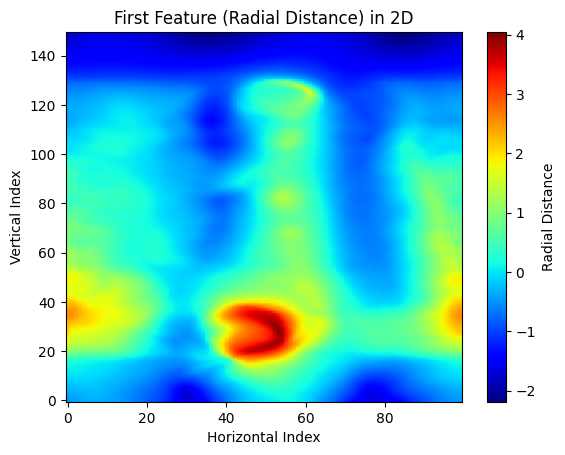

In [15]:
example_rd_tensor = train_dataset[0][0][0]  # shape: (150, 100)

# Convert to NumPy
radial_distance = example_rd_tensor.cpu().numpy() 

# Then plot as before
plt.imshow(radial_distance, origin='lower', cmap='jet', aspect='auto')
plt.colorbar(label="Radial Distance")
plt.title("First Feature (Radial Distance) in 2D")
plt.xlabel("Horizontal Index")
plt.ylabel("Vertical Index")
plt.savefig("first_feature.png", dpi=150, bbox_inches="tight")
plt.show()

Now let's visualize what all 14 channels looks like for one particular sample. Recall that channels 0-6 are from the left hippocampus and channels 7-13 are from the right hippocampus. Note the similarities between the left and right hippocampus. This is not too surprising considering that hippocampus is very similar.

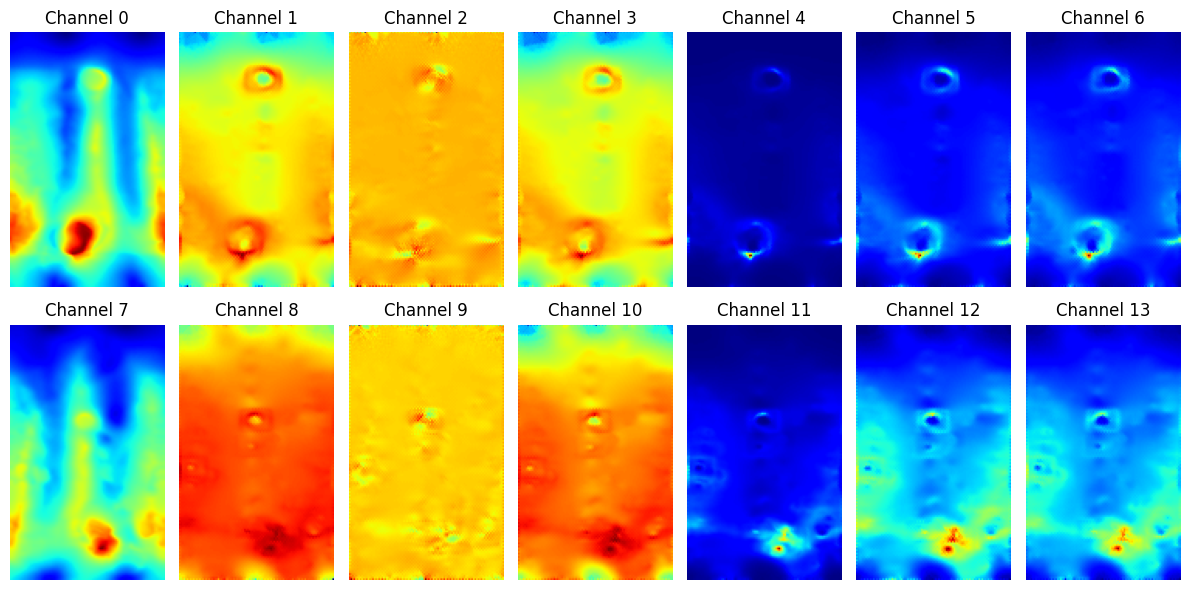

In [16]:
### left hippocampus: channels 0-6; right: channels 7-13 ###
### Here we have the "stacked" data for one  SINGLE patient ###

fig, axes = plt.subplots(2, 7, figsize=(12,6))

for i in range(14):
    ax = axes.flat[i]
    img = train_dataset[2][0][i].cpu().numpy()
    ax.imshow(img, origin='lower', cmap='jet', aspect='auto')
    ax.set_title(f"Channel {i}")
    ax.axis('off')

plt.tight_layout()
plt.savefig("all_channels.png", dpi=150, bbox_inches="tight")
plt.show()

#Check if data is balanced between CN and AD
#print(train_df["DX_NORM"].value_counts())

### Model Training

Here are some helper functions for us to visualize the training process. We can monitor the training and validation loss and accuracy over epochs and create a plot. 

In [17]:
# track training and validation progress
class FinalPlotCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Append training and validation loss at the end of each epoch
        train_loss = trainer.callback_metrics.get("train_loss")
        if train_loss is not None:
            self.train_losses.append(train_loss.cpu().detach().item())
        
        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss is not None:
            self.val_losses.append(val_loss.cpu().detach().item())
        
        # Append training and validation accuracy at the end of each epoch
        train_acc  = trainer.callback_metrics.get("train_acc")
        if train_acc is not None:
            self.train_accs.append(train_acc.cpu().detach().item())

        val_acc = trainer.callback_metrics.get("val_acc")
        if val_acc is not None:
            self.val_accs.append(val_acc.cpu().detach().item())

    #plot training/validation loss and accuracy at the end of training (visual check for overfitting & convergence)
    def on_train_end(self, trainer, pl_module):
        # Plot the losses at the end of training
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label="Train Loss", marker="o")
        plt.plot(self.val_losses, label="Validation Loss", marker="x")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss Over Epochs")
        plt.legend()
        plt.grid(True)
        plt.savefig("loss_curve.png", dpi=150, bbox_inches="tight")
        plt.show()

        # Plot accuracies at the end of training
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_accs, label="Train Accuracy", marker="o")
        plt.plot(self.val_accs, label="Validation Accuracy", marker="x")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Training and Validation Accuracy Over Epochs")
        plt.legend()
        plt.grid(True)
        plt.savefig("train_val_acc.png", dpi=150, bbox_inches='tight')
        plt.show()

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/nas/longleaf/home/fangliu/.conda/envs/torch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https:/

------Training SimpleCNN------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nas/longleaf/home/fangliu/.conda/envs/torch_env/lib/python3.10/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name      | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model     | SimpleCNN        | 7.2 M  | train | 0    
1 | criterion | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.700    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
0         Total Flops
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/nas/longleaf/home/fangliu/.conda/envs/torch_env/lib/python3.10/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/nas/longleaf/home/fangliu/.conda/envs/torch_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


Epoch 0: 100%|██████████| 193/193 [10:51<00:00,  0.30it/s, v_num=10]       
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 193/193 [12:18<00:00,  0.26it/s, v_num=10]    

`Trainer.fit` stopped: `max_epochs=1` reached.


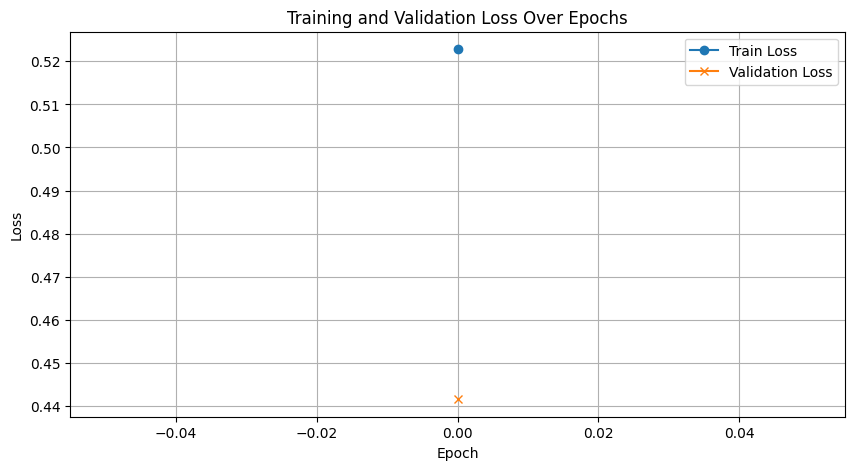

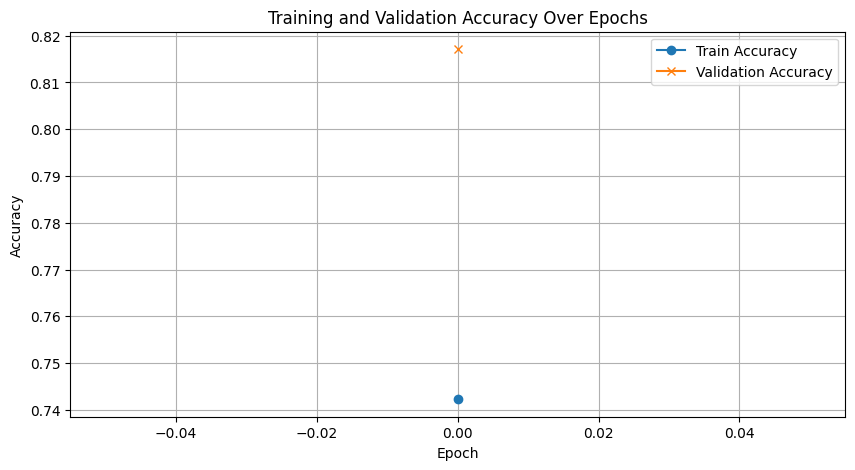

Epoch 0: 100%|██████████| 193/193 [12:19<00:00,  0.26it/s, v_num=10]


In [18]:
#CNN
print("------Training SimpleCNN------")
model = Trainer(model=SimpleCNN(num_classes=2), lr=1e-3)

# Trainer
trainer =  pl.Trainer(
    max_epochs=1, 
    accelerator="gpu",
    devices=1,
    precision="16-mixed",
    enable_progress_bar=True,   # disables ALL tqdm bars (train + val)
    callbacks=[
        FinalPlotCallback(), 
        EarlyStopping(monitor='val_loss', patience=5, mode="min"),
    ],
)

# Training
trainer.fit(model, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nas/longleaf/home/fangliu/.conda/envs/torch_env/lib/python3.10/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name      | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------
0 |

------Training VGG---------
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/nas/longleaf/home/fangliu/.conda/envs/torch_env/lib/python3.10/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/nas/longleaf/home/fangliu/.conda/envs/torch_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


Epoch 0: 100%|██████████| 193/193 [09:14<00:00,  0.35it/s, v_num=11]       
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 193/193 [10:28<00:00,  0.31it/s, v_num=11]    

`Trainer.fit` stopped: `max_epochs=1` reached.


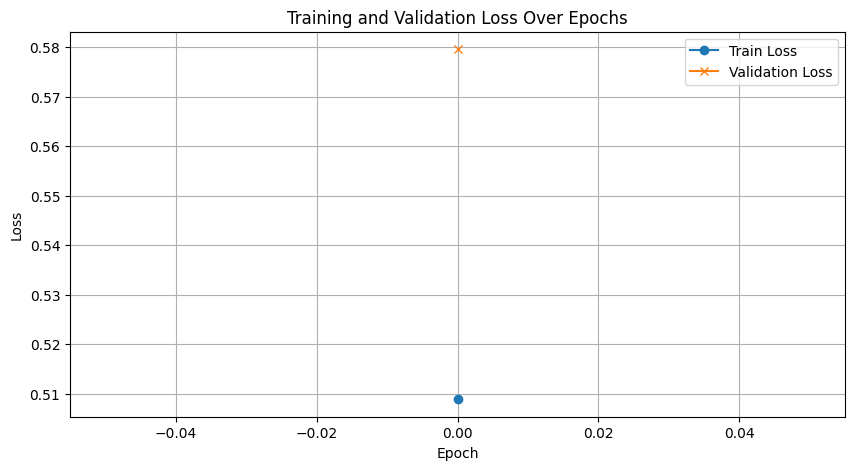

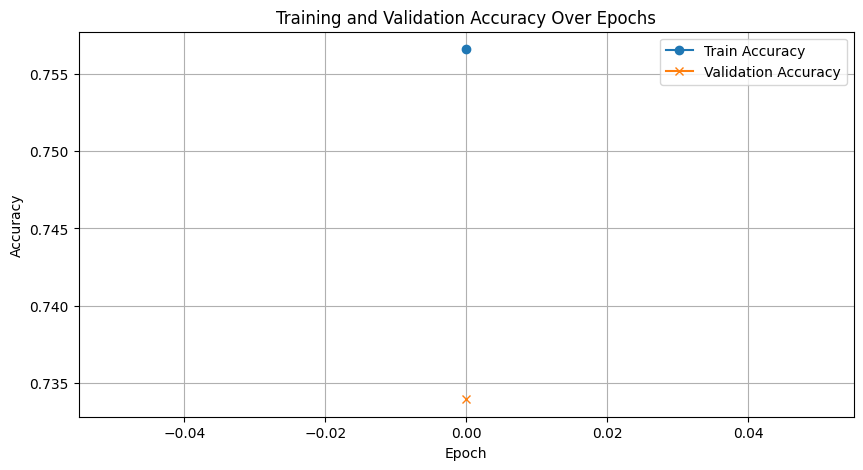

Epoch 0: 100%|██████████| 193/193 [10:29<00:00,  0.31it/s, v_num=11]


In [19]:
print("------Training VGG---------")

model_vgg = VGGLite4(in_channels=14, num_classes=2, dropout=0.5)
lit_model_vgg = Trainer(model=model_vgg, lr=1e-3)

trainer = pl.Trainer(
    max_epochs=1,
    accelerator="gpu",
    devices=1,
    precision="16-mixed",
    enable_progress_bar=True,
    callbacks=[
        FinalPlotCallback(),
        EarlyStopping(monitor="val_loss", patience=5, mode="min"),
    ],
)

trainer.fit(lit_model_vgg, train_loader, val_loader)

### Overfitting Prevention

First let's define what I have in mind when I say overfitting. Usually at the beginning of training, the lower the loss on the training data, the lower the loss on the validation data. However after a # of iteractions on the training data, validation metrics stall and then degradees. This is when overfitting happens - the model is actually learning patterns that is specific to the training data but irrelvant when it comes to new data. To improve generalization and prevent overfitting, we implemented the following. 

- **Early stopping:** Note that earlier in the code, we specifed when training should stop (`EarlyStopping(monitor='val_loss', patience=5, mode="min"),`). More specifically, we watch the validation loss after each epoch and if the loss does not improve for 5 consecutive epochs (i.e., loss does not go down), we stops training. This way we don't waste epochs overfitting and saves time. 

- **Adding dropout:** Earlier we included an dropout layer in our model. This means that we randomly "drop" (setting to zero) a number of output features of the layer during training. Here we set our drop rate at 0.5, implying that half of the features are zeroed out. The idea here is that introducing noise in output values of a layer can break up happenstance patterns that aren't signicant (without noise the model might start memorizing patterns and result in overfitting).

- **Reducing network size**: We used pooling to reduce the network size so that the model have to learn compressed representations that have predictive power regarding the targets, insteading of using memorization resources are possible "noise" in the data. However, finding the right balance so that we don't overfitting while also not underfitting could be challenging. Typically we start with a small # of layers and the increase the size of layers or add new layers until there is diminishing returns on validation loss. 

##  4. Model Evaluation

### Performance Metrics

Next, we could evaluate the model on the **validation** set using the following metrics: accuracy, precision, recall, F1-score, and ROC-AUC curve. 

In [20]:
def validation(model, test_loader, class_names=("CN", "AD")):
    
    """
    Multi-class evaluation (CN/AD) with weighted metrics + macro metrics.
    Computes ROC-AUC using softmax probabilities (OVR).
    """
    model.eval()

    # pick the model's device (works for LightningModule or plain nn.Module)
    device = next(model.parameters()).device

    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for data, labels in test_loader:
            
            data = data.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).long()

            logits = model(data)

            # Fix batch_size==1 squeeze issue: [2] -> [1,2]
            if logits.dim() == 1:
                logits = logits.unsqueeze(0)

            if logits.dim() != 2:
                raise ValueError(f"Unexpected logits shape {tuple(logits.shape)}; expected [B, C].")

            C = logits.shape[1]
            if C != 2:
                raise ValueError(
                    f"Model outputs C={C} classes, but binary testing expects 2. "
                    f"Make sure SimpleCNN(num_classes=2) and the final layer matches CN/AD."
                )

            probs = torch.softmax(logits, dim=1)      # [B,2]
            pred  = torch.argmax(probs, dim=1)        # [B]

            y_true.extend(labels.detach().cpu().numpy().tolist())
            y_pred.extend(pred.detach().cpu().numpy().tolist())
            y_prob.extend(probs[:, 1].detach().cpu().numpy().tolist())  # P(AD)

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_prob = np.asarray(y_prob)

    #Import necessary evaluation metrics
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        roc_auc_score, classification_report, confusion_matrix
    )
    
    # Core metrics
    acc    = accuracy_score(y_true, y_pred)
    prec_w = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec_w  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1_w   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    # Macro metrics (often nicer under imbalance)
    prec_m = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec_m  = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1_m   = f1_score(y_true, y_pred, average="macro", zero_division=0)

    # ROC-AUC (binary): uses probabilities of the positive class (AD)
    roc_auc = None
    try:
        roc_auc = roc_auc_score(y_true, y_prob)
    except ValueError as e:
        print(f"[WARN] ROC-AUC not computed: {e}")

    print(f"Test Accuracy:        {acc:.4f}")
    print(f"Test Precision(w):    {prec_w:.4f}")
    print(f"Test Recall(w):       {rec_w:.4f}")
    print(f"Test F1(w):           {f1_w:.4f}")
    #print(f"Test Precision(m):    {prec_m:.4f}")
    #print(f"Test Recall(m):       {rec_m:.4f}")
    #print(f"Test F1(m):           {f1_m:.4f}")
    if roc_auc is not None:
        print(f"Test ROC-AUC(weighted, ovr):         {roc_auc:.4f}")

    # Diagnostics
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    print("\nConfusion Matrix (rows=true, cols=pred) [CN, AD]:")
    print(cm)

    # Make sure class_names length matches 2
    print("\nClassification Report:")
    print(classification_report(
        y_true, y_pred,
        target_names=list(class_names),
        digits=4,
        zero_division=0
    ))

    return {
        "accuracy": acc,
        "precision_weighted": prec_w,
        "recall_weighted": rec_w,
        "f1_weighted": f1_w,
        "precision_macro": prec_m,
        "recall_macro": rec_m,
        "f1_macro": f1_m,
        "roc_auc": roc_auc
    }


In [21]:
print()
print("--------Evaluating SimpleCNN--------")
validation(model, val_loader)
print()


--------Evaluating SimpleCNN--------


/nas/longleaf/home/fangliu/.conda/envs/torch_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


Test Accuracy:        0.8171
Test Precision(w):    0.8196
Test Recall(w):       0.8171
Test F1(w):           0.8092
Test ROC-AUC(weighted, ovr):         0.8628

Confusion Matrix (rows=true, cols=pred) [CN, AD]:
[[252  18]
 [ 59  92]]

Classification Report:
              precision    recall  f1-score   support

          CN     0.8103    0.9333    0.8675       270
          AD     0.8364    0.6093    0.7050       151

    accuracy                         0.8171       421
   macro avg     0.8233    0.7713    0.7862       421
weighted avg     0.8196    0.8171    0.8092       421




In [22]:
print("------Evaluating VGG--------")
validation(lit_model_vgg, val_loader)
print()

------Evaluating VGG--------
Test Accuracy:        0.7340
Test Precision(w):    0.7789
Test Recall(w):       0.7340
Test F1(w):           0.6873
Test ROC-AUC(weighted, ovr):         0.8536

Confusion Matrix (rows=true, cols=pred) [CN, AD]:
[[265   5]
 [107  44]]

Classification Report:
              precision    recall  f1-score   support

          CN     0.7124    0.9815    0.8255       270
          AD     0.8980    0.2914    0.4400       151

    accuracy                         0.7340       421
   macro avg     0.8052    0.6364    0.6328       421
weighted avg     0.7789    0.7340    0.6873       421




### Interpret the Results

**NOTE:** The final numbers from the slurm output will be different from the #'s show above since the #'s above are based on 1 epoch test runs to make sure the code is running correctly! Please refer to the final slurm output file for final numbers! 

Let's take a look at the model evaluation metrics and see what they mean: 
- **Accuracy:** It measures the proportion of total predictions (both AD and CN) that were correct (TP + TN)/(TP + TN + FP + FN). Note: If the dataset is imbalanced (e.g., 90% CN and 10% AD), then the model could simply guess "CN" every time and get 90% accuracy while actually failing to find a single person with Alzheimer's. Thus, we can't simply look at accuracy to assess how good our model is. A balanced dataset is important. 

- **Precision (Positive predictive value):** Of all the patients my CNN labled as AD, how many actually had the disease? The focus here is to minimize the # of false positives (i.e., labeling a healthy person as having AD).

- **Recall (also known as sensitivity):** Of all patients who actually had AD, how many did my CNN successfully catch? Focus here is to minimize # of false negatives (i.e., telling someone with AD they are healthy). For medical screening, this is usually the most important. We don't want to miss diagnosis that needs early intervention, especially for a disease such as AD that benefits greatly from early detection. 

- **F1-score:** The harmonic mean of precision and recall (a single score that balances both). This is often a much better indicator of model health than accuracy when we have uneven class distribution.

- **ROC-AUC curve:** A measure that tells us how well the model separates the two classes. A high AUC means CNN is very good at ranking AD patients' probability higher than CN patients' probability. 

**SimpleCNN**

*Strengths:* The evaluation metrics are all very high (80%+). The high accuracy indicate the model's ability to identify true positive and negative cases. The precision is also very good, meaning majority of the patients the CNN labeled as AD actually do have the disease.

*Weaknesses:* Note that recall/sensitivity is generally lower for AD cases than CNs. This means that of all the patients who actually have AD, the CNN is only able to catch a portion. This implies there is a considerable number of false negatives where we fail to identify those needing early intervention. This is not too surprising considering that of the **421** samples in the validation set, about 65% are CN. This class imbalance likely caused the recall difference observed between AD and CNs. This reduced recall is also reflected in the lower f1-score for AD. 


## 5. Test Set Prediction

Next, we could use the trained model to predict AD status for the test set subjects. Create a CSV file with two columns: `SubjectID` and `PredictedLabel` (0=healthy, 1=AD).

In [23]:
def testing(model, test_dataset, test_loader, subject_ids):

    model.eval()
    preds = []

    # pick the model's device (works for LightningModule or plain nn.Module)
    device = next(model.parameters()).device

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).long()

            logits = model(data)

            # Fix batch_size==1 squeeze issue: [2] -> [1,2]
            if logits.dim() == 1:
                logits = logits.unsqueeze(0)

            if logits.dim() != 2:
                raise ValueError(f"Unexpected logits shape {tuple(logits.shape)}; expected [B, C].")

            C = logits.shape[1]
            if C != 2:
                raise ValueError(
                    f"Model outputs C={C} classes, but binary testing expects 2. "
                    f"Make sure SimpleCNN(num_classes=2) and the final layer matches CN/AD."
                )

            probs = torch.softmax(logits, dim=1)      # [B,2]
            pred  = torch.argmax(probs, dim=1)        # [B]
            preds.extend(pred.cpu().numpy().tolist())
    
    predictions = pd.DataFrame({
        "SubjectID": subject_ids,
        "PredictedLabel": preds
    })
    
    return predictions

In [24]:
print()
print("------ Testing SimpleCNN ------")
predictions_cnn = testing(model, test_dataset, test_loader, subject_ids = test_dataset.df["PTID"].values)

#save the predictions to a CSV file
#Note: testing set contain 353 samples.

predictions_cnn.to_csv("hw1_SimpleCNN.csv", index=False)
print("Predicted AD status is saved (CNN)!")



------ Testing SimpleCNN ------


/nas/longleaf/home/fangliu/.conda/envs/torch_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


Predicted AD status is saved (CNN)!


In [25]:
print()
print("------Testing VGG---------")
predictions_vgg = testing(lit_model_vgg, test_dataset, test_loader, subject_ids = test_dataset.df["PTID"].values)
predictions_vgg.to_csv("hw1_vgg.csv", index=False)
print("Predicted AD status is saved (VGG)!")



------Testing VGG---------
Predicted AD status is saved (VGG)!


## 6. Discussion and Conclusion

### Biomedical Implications

Early detection of AD could help improve disease prognostics and potentially delay or slow down the progression of the disease. Thus, having reliable biomarkers of AD onset can make a big difference in the prevention and treatment of AD. [According to one paper](https://www.sciencedirect.com/science/article/pii/S1934590923000024), the hippocampus is an critical hub for cognition and memory, and it is one of the first brain regions to be affected in AD patients. Through this homework, we demonstrated that deep learning approaches such as convolutional neural networks using hippocampal data could be used to distinguish CN and AD cases. Thus, we can develop imaging techniques to identify features that could inform AD progression and implement them in routine clinical practice, thus resulting in earlier detection and better disease outcomes. 

### Challenges & Limitations

One key challenge during the assignment was the set up. For instance, I had multiple errors when setting up the environment on the high computing cluster (i.e., module not existing, kernels not available, installation errors). The queue for GPU also took an unexpectedly very long time (my job was in queue for almost a day). The other issue was running the slurm bash script so the job could be run remotely in the background – many errors were encountered during the process so debugging took a quite bit of time. Putting the technicalities aside, implementation of the actual CNN also had its own challenges. Since tensor is the primary unit CNN uses, understanding the data is crucial. If data processing is done inappropriately, then everything else that follows is affected. The CNN architecture looked quite complicated first, but understanding key concepts such convolution, strides, and padding were super important and helped me understand what is actually happening in the background. For instance, knowing the feature map shape after each layer was helpful for troubleshooting and for understanding how data was processed. On the project level, one noticeable challenge was the class imbalance. There were more CN than AD samples (2397 vs. 1458). This could be one of the reasons why the models predicted majority of CN class. To improve this, we can get more AD cases so that the class is more balanced. As an alternative approach, we could also consider residual network (ResNet). ResNet is innovative because instead of forcing every layer to learn a brand-new representation of the data, it allows model to learn the difference (hence the key word “residual”) between the input and the output. ResNet can also scale up the number of layers, thereby extracting more complex and hierarchical features than shallower methods. 